# [EP-11] 어제 오른 내 주식, 과연 내일은?

## Step 1. 시계열 데이터 준비 - 삼성전자

  - 칼럼 종류 : Date, Open, High, Low, Close, Adj Close, Volume
  - 날짜별로 시작가, 최고가, 최적가, 종가, 수정종가, 거래량이 저장되어 있는 것을 확인할 수 있다.
  - 우리는 종가(Close)만 사용한다.

In [1]:
# 사용할 라이브러리 및 데이터 준비

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from statsmodels.tsa.stattools import adfuller

# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

## Step 2. 각종 전처리 수행
  - 결측치 처리 및 로그 변환

In [2]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

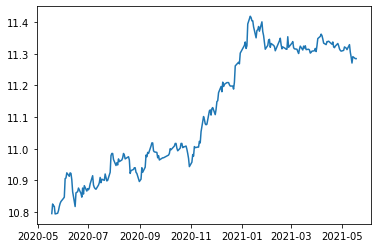

In [3]:
# 로그 변환
ts_log = np.log(ts)
plt.plot(ts_log)

## Step 3. 시계열 안정성 분석
  - 정성적 그래프 분석
  - 정량적 Augmented Dicky - Fuller Test
  - 시계열 분해(Time Series Decomposition)
  - Residual 안정성 확인

In [4]:
# 정성적 그래프 분석

def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('good')

good


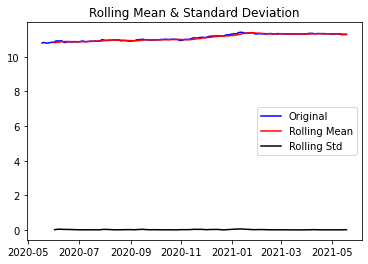

In [5]:
plot_rolling_statistics(ts_log, window=12)

In [6]:
# 정량적 Augmented Dicky - Fuller Test

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('good')

good


In [7]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


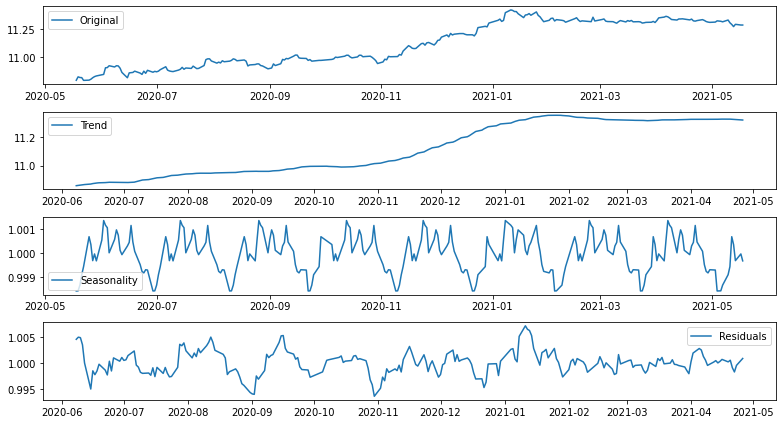

In [8]:
# 시계열 분해(Time Series Decompostion)

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [9]:
# Residual 안정성 확인

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


## Step 4. 학습, 테스트 데이터셋 생성

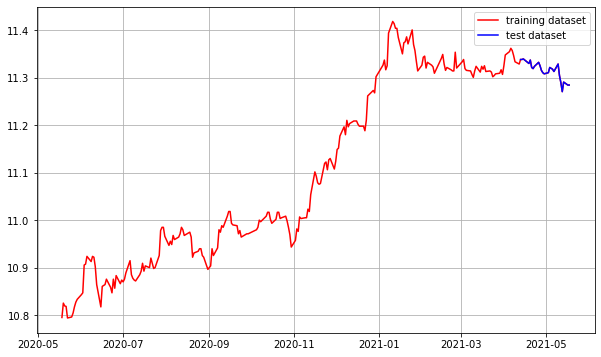

In [10]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## Step 5. 정적 ARIMA 모수 찾기
  - ACF, PACF 그려보기 -> p, q 구하기
  - 차분 안정성 확인 -> d 구하기

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


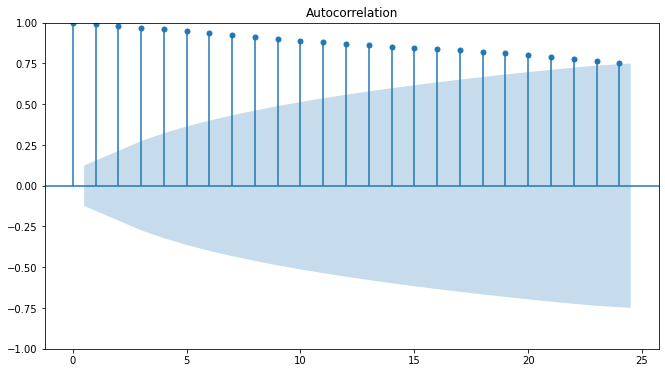

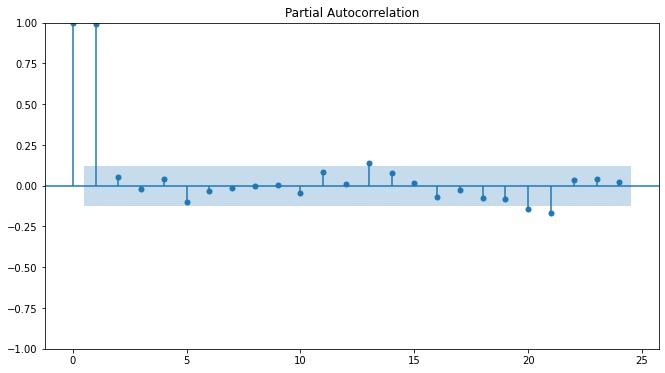

In [11]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


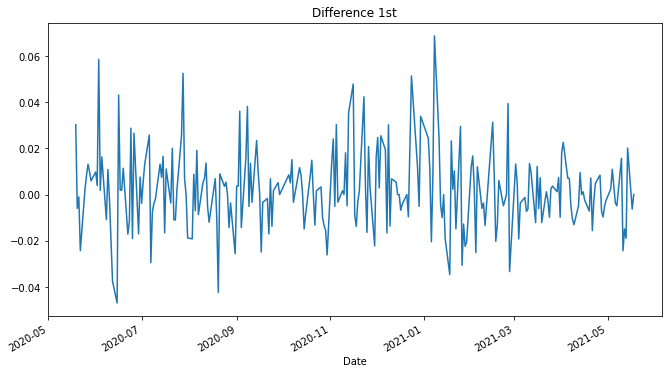

In [12]:
# 차분 안정성 확인 -> d 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

## Step 6. ARIMA 모델 훈련과 테스트
  - ARIMA 모델 빌드와 훈련
  - 모델 테스트 및 플로팅
  - 최종 예측 모델 정확도 측정(MAPE)

In [13]:
# Build and Train  Model

from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(1, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 583.370
Date:                Thu, 10 Feb 2022   AIC                          -1158.741
Time:                        08:32:27   BIC                          -1145.076
Sample:                             0   HQIC                         -1153.226
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.127     87.360      0.000      10.841      11.338
ar.L1          0.9942      0.006    157.934      0.000       0.982       1.007
ma.L1          0.0392      0.063      0.623      0.5

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


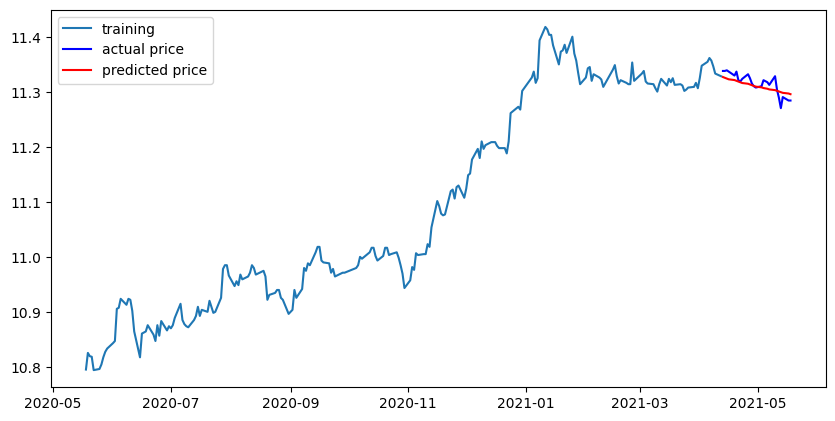

In [14]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [15]:
# 최종 예측 모델 정확도 측정(MAPE)

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))


MSE:  1057119.8161340475
MAE:  850.8270312480739
RMSE:  1028.1633217218202
MAPE: 1.04%


# 두번째 데이터 - ASML Holding

## Step 1. 시계열 데이터 준비

In [16]:
# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/ASML.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts_1 = df['Close']

ts_1.head()

Date
2021-02-10    566.890015
2021-02-11    591.510010
2021-02-12    597.989990
2021-02-16    603.140015
2021-02-17    587.580017
Name: Close, dtype: float64

## Step 2. 각종 전처리 수행

In [17]:
# 결측치 처리
ts_1 = ts_1.interpolate(method='time')
ts_1[ts_1.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

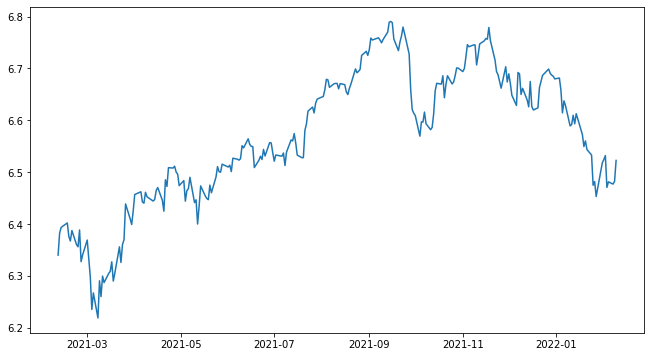

In [18]:
# 로그 변환
ts_1_log = np.log(ts_1)
plt.plot(ts_1_log)

## Step 3. 시계열 안정성 분석

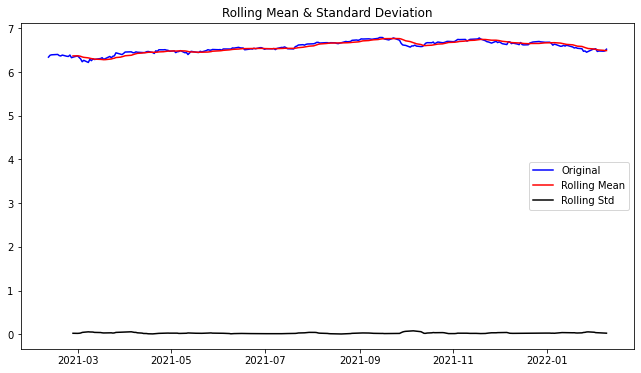

In [19]:
# 정성적 그래프 분석

plot_rolling_statistics(ts_1_log, window = 12)

In [20]:
# 정량적 Augmented Dicky - Fuller Test

augmented_dickey_fuller_test(ts_1_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.645642
p-value                          0.459314
#Lags Used                       1.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


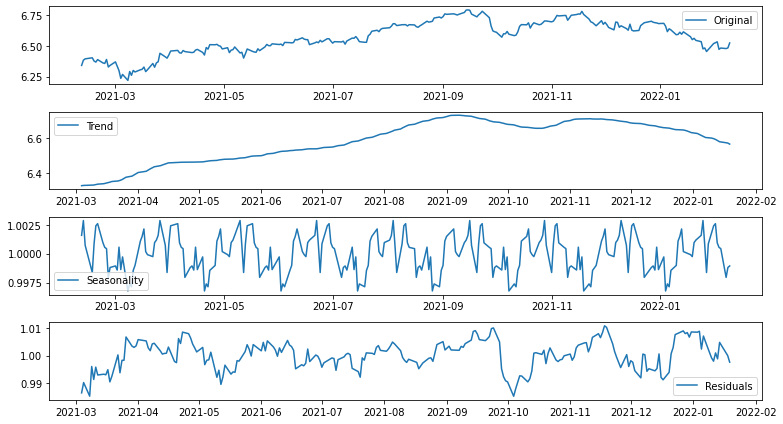

In [21]:
# 시계열 분해(Time Series Decomposition)

decomposition = seasonal_decompose(ts_1_log, model='multiplicative', period = 30) 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_1_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [22]:
# Residual 안정성 확인

residual.dropna(inplace = True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -4.977249
p-value                          0.000025
#Lags Used                       6.000000
Number of Observations Used    216.000000
Critical Value (1%)             -3.460992
Critical Value (5%)             -2.875016
Critical Value (10%)            -2.573952
dtype: float64


## Step 4. 학습, 테스트 데이터셋 생성

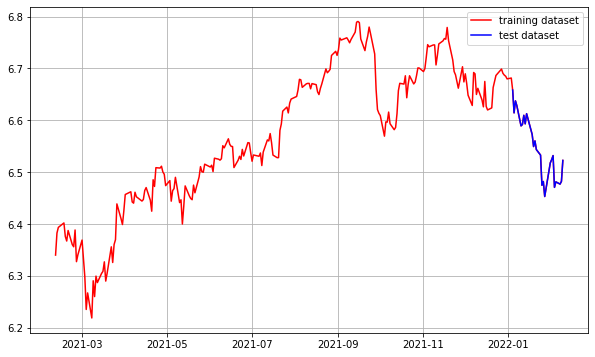

In [23]:
train_1_data, test_1_data = ts_1_log[:int(len(ts_1_log)*0.9)], ts_1_log[int(len(ts_1_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_1_log, c='r', label='training dataset')  # train_1_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_1_log를 선택
plt.plot(test_1_data, c='b', label='test dataset')
plt.legend()

## Step 5. 적정 ARIMA 모수 찾기

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


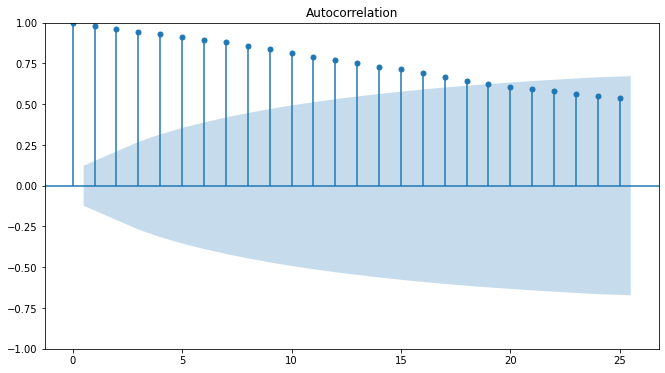

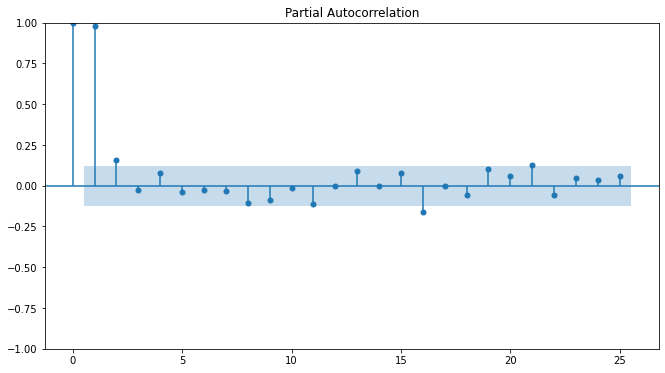

In [24]:
# ACF, PACF 그려보기 - > p , q 값 구하기

plot_acf(ts_1_log)
plot_pacf(ts_1_log)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.809355e+01
p-value                        2.565902e-30
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64


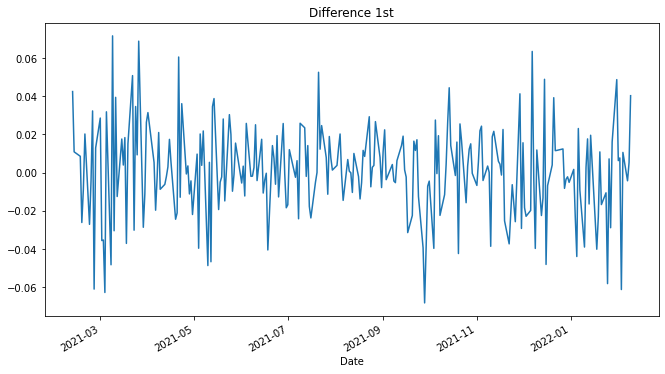

In [25]:
# 차분 안정성 확인 -> d값 구하기

diff_1 = ts_1_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

## Step 6. ARIMA 모델 훈련과 테스트

In [26]:
# build and train model

model = ARIMA(train_1_data, order=(1, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 530.000
Date:                Thu, 10 Feb 2022   AIC                          -1051.999
Time:                        08:32:29   BIC                          -1038.299
Sample:                             0   HQIC                         -1046.471
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.5422      0.097     67.426      0.000       6.352       6.732
ar.L1          0.9910      0.008    118.005      0.000       0.975       1.007
ma.L1         -0.1332      0.058     -2.311      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


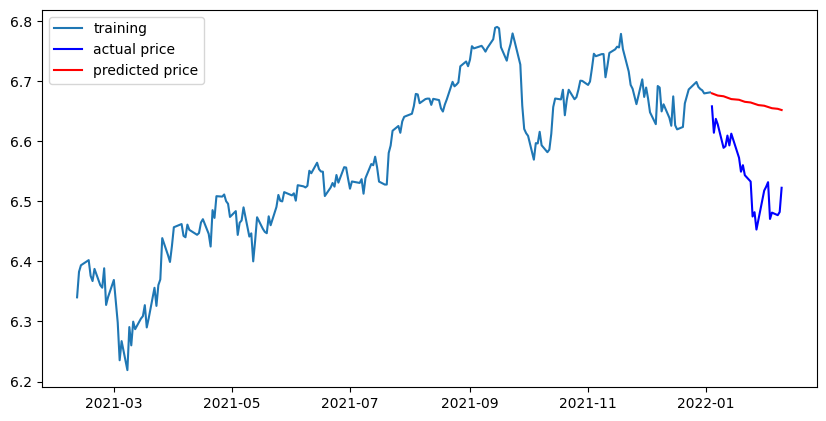

In [27]:
# Forecast : 결과가 fc_1에 담깁니다.

fc_1 = fitted_m.forecast(len(test_1_data), alpha=0.05)  # 95% conf
fc_1 = np.array(fc_1)
# Make as pandas series
fc_series_1 = pd.Series(fc_1, index=test_1_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_1_data, label='training')
plt.plot(test_1_data, c='b', label='actual price')
plt.plot(fc_series_1, c='r',label='predicted price')
plt.legend()
plt.show()

In [28]:
# 최종 예측 모델 정확도 측정(MAPE)

mse = mean_squared_error(np.exp(test_1_data), np.exp(fc_1))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_1_data), np.exp(fc_1))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_1_data), np.exp(fc_1)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc_1) - np.exp(test_1_data))/np.abs(np.exp(test_1_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  8981.703216213913
MAE:  87.60284413138862
RMSE:  94.77184822622124
MAPE: 12.92%


# 세번째 데이터 - Apple

## Step 1. 시계열 데이터 준비

In [29]:
# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/AAPL.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts_2 = df['Close']

ts_2.head()

Date
2021-02-10    135.389999
2021-02-11    135.130005
2021-02-12    135.369995
2021-02-16    133.190002
2021-02-17    130.839996
Name: Close, dtype: float64

## Step 2. 각종 전처리 수행

In [30]:
# 결측치 처리
ts_2 = ts_2.interpolate(method='time')
ts_2[ts_2.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

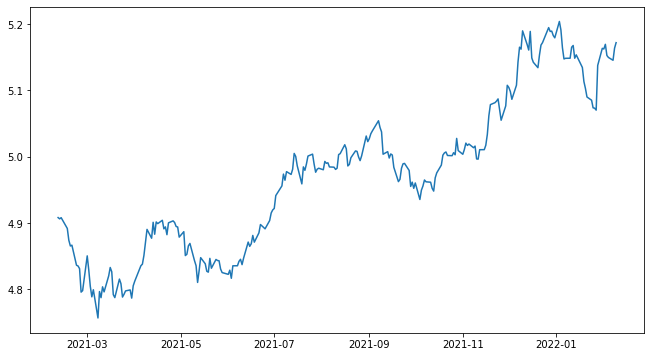

In [31]:
# 로그 변환
ts_2_log = np.log(ts_2)
plt.plot(ts_2_log)

## Step 3. 시계열 안정성 분석

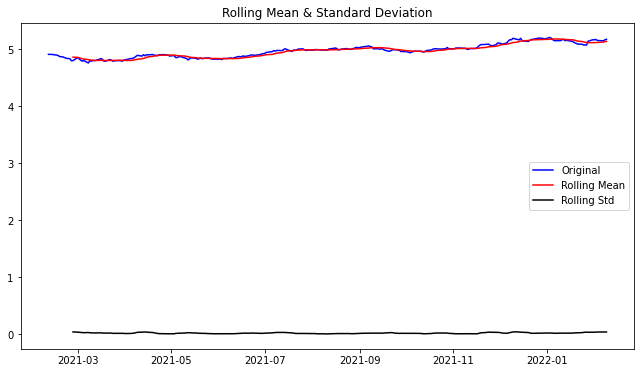

In [32]:
# 정성적 그래프 분석

plot_rolling_statistics(ts_2_log, window = 12)

In [33]:
# 정량적 Augmented Dicky - Fuller Test

augmented_dickey_fuller_test(ts_2_log)

Results of Dickey-Fuller Test:
Test Statistic                  -0.410001
p-value                          0.908416
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


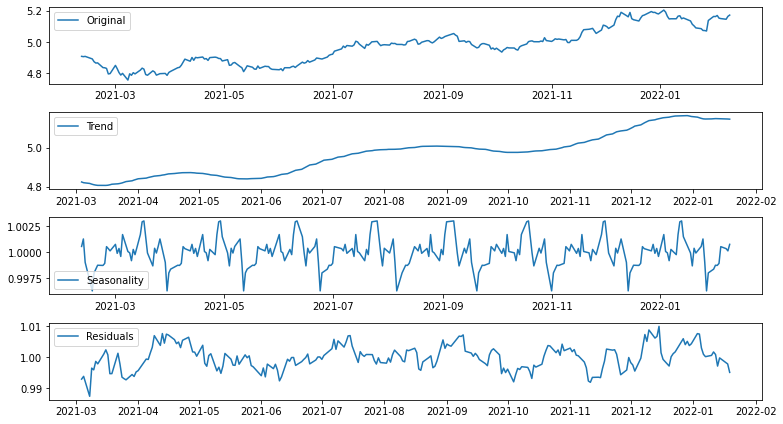

In [34]:
# 시계열 분해(Time Series Decomposition)

decomposition = seasonal_decompose(ts_2_log, model='multiplicative', period = 30) 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_2_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [35]:
# Residual 안정성 확인

residual.dropna(inplace = True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -4.747775
p-value                          0.000068
#Lags Used                       6.000000
Number of Observations Used    216.000000
Critical Value (1%)             -3.460992
Critical Value (5%)             -2.875016
Critical Value (10%)            -2.573952
dtype: float64


## Step 4. 학습, 테스트 데이터셋 생성

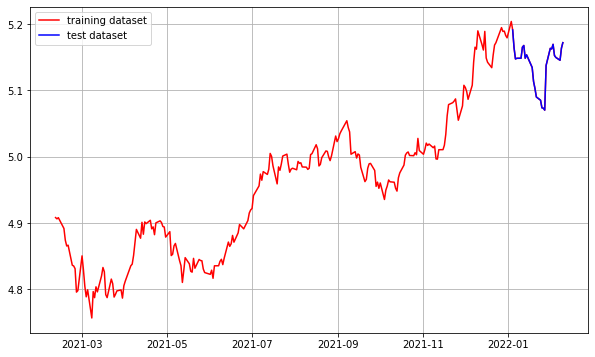

In [36]:
train_2_data, test_2_data = ts_2_log[:int(len(ts_2_log)*0.9)], ts_2_log[int(len(ts_2_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_2_log, c='r', label='training dataset')  # train_1_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_1_log를 선택
plt.plot(test_2_data, c='b', label='test dataset')
plt.legend()

## Step 5. 적정 ARIMA 모수 찾기

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


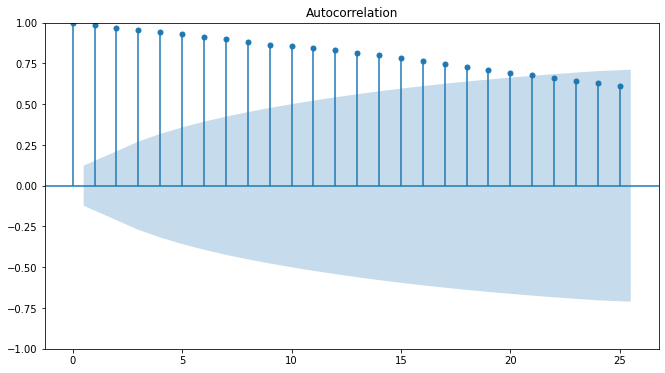

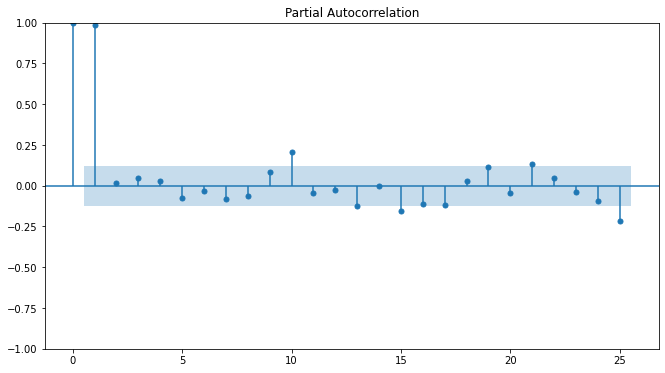

In [37]:
# ACF, PACF 그려보기 - > p , q 값 구하기

plot_acf(ts_2_log)
plot_pacf(ts_2_log)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -9.969701e+00
p-value                        2.257472e-17
#Lags Used                     2.000000e+00
Number of Observations Used    2.490000e+02
Critical Value (1%)           -3.456888e+00
Critical Value (5%)           -2.873219e+00
Critical Value (10%)          -2.572994e+00
dtype: float64


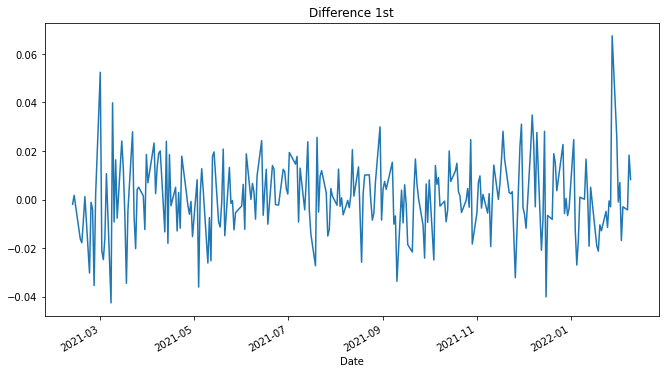

In [38]:
# 차분 안정성 확인 -> d값 구하기

diff_2 = ts_2_log.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_2)

## Step 6. ARIMA 모델 훈련과 테스트

In [70]:
# build and train model

model = ARIMA(train_2_data, order=(1, 0, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 626.711
Date:                Thu, 10 Feb 2022   AIC                          -1247.422
Time:                        08:42:42   BIC                          -1237.147
Sample:                             0   HQIC                         -1243.275
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0123      0.123     40.760      0.000       4.771       5.253
ar.L1          0.9938      0.007    142.924      0.000       0.980       1.007
sigma2         0.0002   1.95e-05     11.751      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


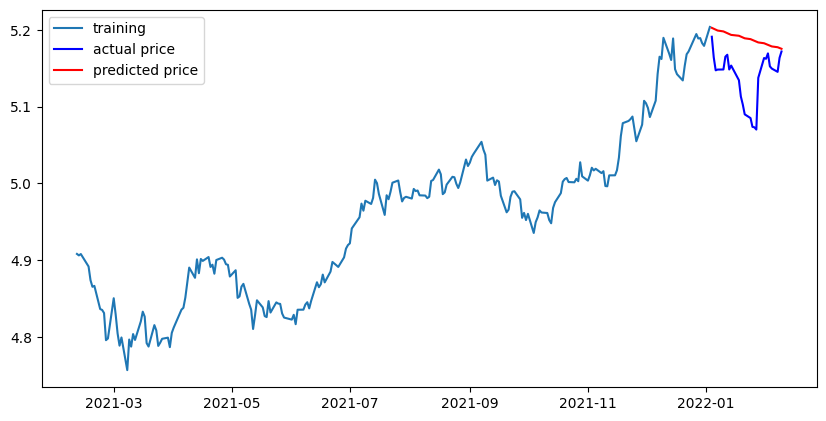

In [71]:
# Forecast : 결과가 fc_2에 담깁니다.

fc_2 = fitted_m.forecast(len(test_2_data), alpha=0.05)  # 95% conf
fc_2 = np.array(fc_2)
# Make as pandas series
fc_series_2 = pd.Series(fc_2, index=test_2_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_2_data, label='training')
plt.plot(test_2_data, c='b', label='actual price')
plt.plot(fc_series_2, c='r',label='predicted price')
plt.legend()
plt.show()

In [72]:
# 최종 예측 모델 정확도 측정(MAPE)

mse = mean_squared_error(np.exp(test_2_data), np.exp(fc_2))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_2_data), np.exp(fc_2))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_2_data), np.exp(fc_2)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc_2) - np.exp(test_2_data))/np.abs(np.exp(test_2_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  109.68461898079589
MAE:  8.747427137342957
RMSE:  10.473042489209899
MAPE: 5.25%


# 네번째 데이터 - Activision Blizzard

## Step 1. 시계열 데이터 준비

In [42]:
# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/ATVI.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts_3 = df['Close']

ts_3.head()

Date
2021-02-10    102.760002
2021-02-11    103.239998
2021-02-12    103.809998
2021-02-16    102.959999
2021-02-17    102.349998
Name: Close, dtype: float64

## Step 2. 각종 전처리 수행

In [43]:
# 결측치 처리
ts_3 = ts_3.interpolate(method='time')
ts_3[ts_3.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

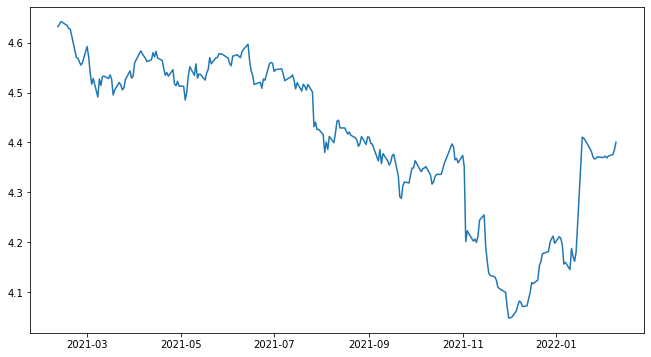

In [44]:
# 로그 변환
ts_3_log = np.log(ts_3)
plt.plot(ts_3_log)

## Step 3. 시계열 안정성 분석

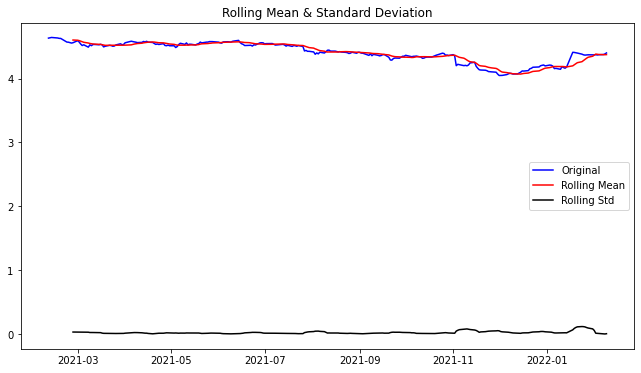

In [45]:
# 정성적 그래프 분석

plot_rolling_statistics(ts_3_log, window = 12)

In [46]:
# 정량적 Augmented Dicky - Fuller Test

augmented_dickey_fuller_test(ts_3_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.640939
p-value                          0.461770
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


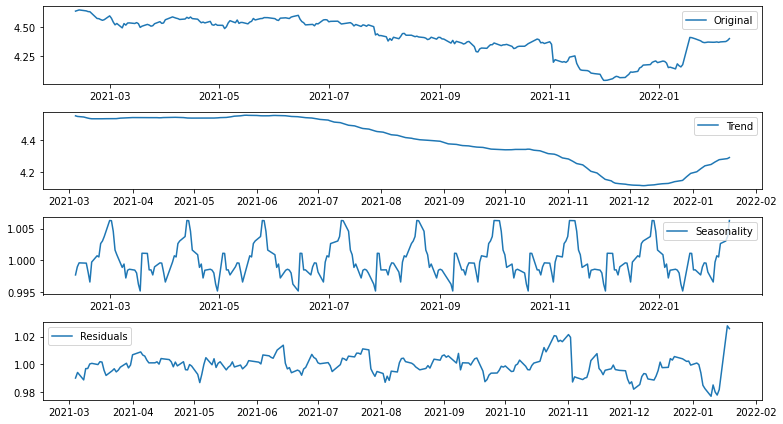

In [47]:
# 시계열 분해(Time Series Decomposition)

decomposition = seasonal_decompose(ts_3_log, model='multiplicative', period = 30) 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_3_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [48]:
# Residual 안정성 확인

residual.dropna(inplace = True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -5.935120e+00
p-value                        2.330773e-07
#Lags Used                     5.000000e+00
Number of Observations Used    2.170000e+02
Critical Value (1%)           -3.460849e+00
Critical Value (5%)           -2.874953e+00
Critical Value (10%)          -2.573919e+00
dtype: float64


## Step 4. 학습, 테스트 데이터셋 생성

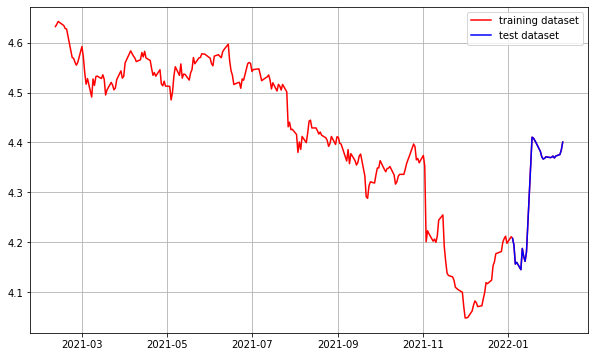

In [49]:
train_3_data, test_3_data = ts_3_log[:int(len(ts_3_log)*0.9)], ts_3_log[int(len(ts_3_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_3_log, c='r', label='training dataset')  # train_1_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_1_log를 선택
plt.plot(test_3_data, c='b', label='test dataset')
plt.legend()

## Step 5. 적정 ARIMA 모수 찾기

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


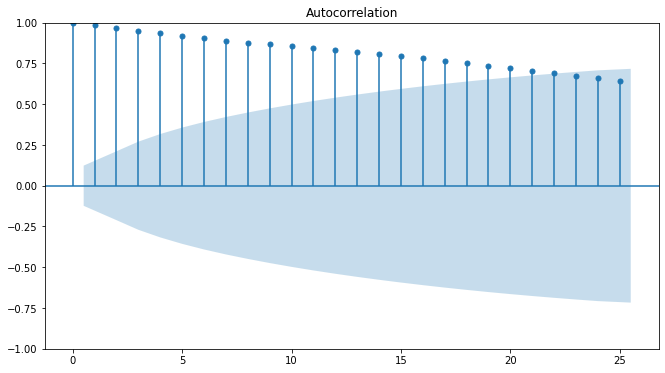

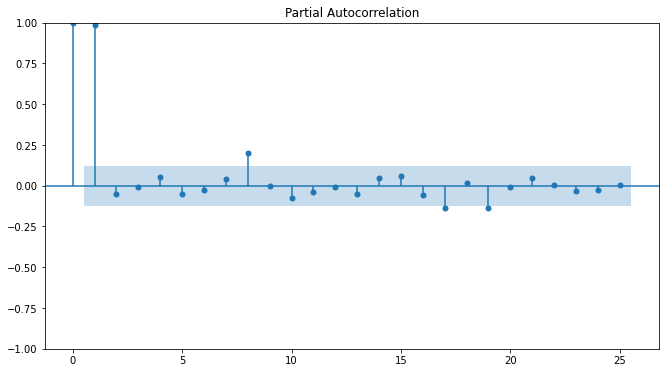

In [50]:
# ACF, PACF 그려보기 - > p , q 값 구하기

plot_acf(ts_3_log)
plot_pacf(ts_3_log)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.529093e+01
p-value                        4.444262e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64


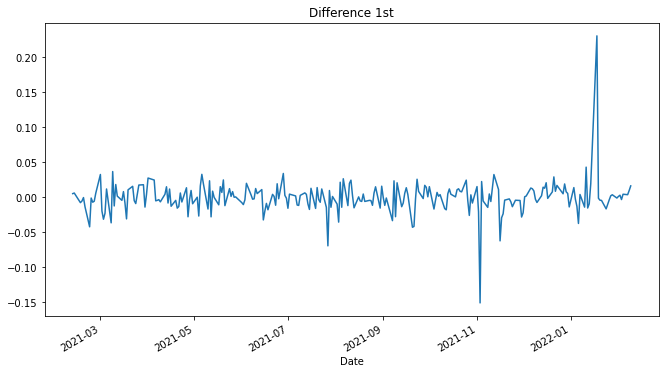

In [51]:
# 차분 안정성 확인 -> d값 구하기

diff_3 = ts_3_log.diff(periods=1).iloc[1:]
diff_3.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_3)

## Step 6. ARIMA 모델 훈련과 테스트

In [68]:
# build and train model

model = ARIMA(train_3_data, order=(0, 0, 2))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(0, 0, 2)   Log Likelihood                 329.554
Date:                Thu, 10 Feb 2022   AIC                           -651.109
Time:                        08:42:09   BIC                           -637.409
Sample:                             0   HQIC                          -645.580
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4198      0.014    322.620      0.000       4.393       4.447
ma.L1          1.4203      0.042     33.921      0.000       1.338       1.502
ma.L2          0.7747      0.042     18.664      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as st

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


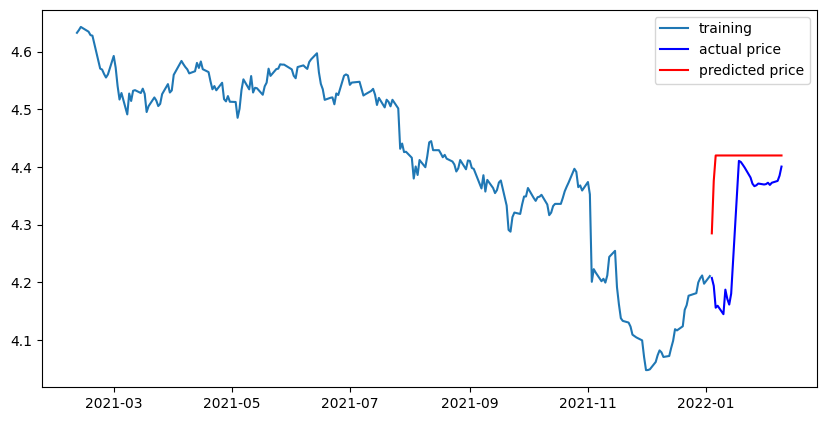

In [69]:
# Forecast : 결과가 fc_2에 담깁니다.

fc_3 = fitted_m.forecast(len(test_3_data), alpha=0.05)  # 95% conf
fc_3 = np.array(fc_3)
# Make as pandas series
fc_series_3 = pd.Series(fc_3, index=test_3_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_3_data, label='training')
plt.plot(test_3_data, c='b', label='actual price')
plt.plot(fc_series_3, c='r',label='predicted price')
plt.legend()
plt.show()

In [65]:
# 최종 예측 모델 정확도 측정(MAPE)

mse = mean_squared_error(np.exp(test_3_data), np.exp(fc_3))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_3_data), np.exp(fc_3))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_3_data), np.exp(fc_3)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc_3) - np.exp(test_3_data))/np.abs(np.exp(test_3_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  108.61060804782763
MAE:  7.738044345401999
RMSE:  10.421641331759005
MAPE: 11.39%


## 회고
1. 좋았던 점

  - 이번 노드를 통해서 시계열 예측이라는 새로운 개념을 알게 되서 꽤 흥미로웠다.
  - 특히 예측한 결과를 바로 확인할 수 있고 모델 훈련에 시간이 오래 걸리지 않는다는게 좋았다.
  - 크게 어려운 부분들이 없이 데이터 전처리 부분도 간단하게 진행되서 시간이 오래 걸리진 않았다.
  
  
2. 어려웠던 점

  - 이번 노드에서 가장 크게 고려해야 할 부분은 ARIMA 모델의 모수를 구해서 입력해주는 부분이었다.
  - 노드에서 일반적인 시계열 데이터는 AR이나 MA 성향 중 한개의 성향을 가지기 때문에 p + q < 2 / p * q = 0 수식이 된다고 하였는데 여기가 잘 이해되지 않았다.
  - 노드에서 알려주는 수식과 실제로 코드에 입력되는 값이 달랐기 때문이다.
  - 삼성전자 데이터에서는 p, d, q의 값이 2, 0, 1이 들어갔는데 노드에서 알려준 p + q < 2 / p * q = 0과 맞지 않은 내용이었다.
  - 그래서 p + q < 2 / p * q = 0에 맞지 않게 진행해보고 p + q < 2 / p * q = 0에 맞게 진행을 해보았다.
  - p + q < 2 / p * q = 0 수식에 맞게 p와 q의 값을 지정해주었을 때 조금 더 좋은 결과를 얻을 수 있었다.
  - 이 부분에 대해서 구글에서도 검색을 해보았지만 아직도 정확하게 이해되지는 않는다.